# Importing and Filtering Data from Odin

In [1]:
import sqlalchemy

import pandas as pd
import numpy as np
import datetime


import urllib.parse

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.colors as colors

In [2]:
# Set up the connection to the SQL Server using Windows Authentication
params = urllib.parse.quote_plus('Driver={SQL Server};Server=Odin;Trusted_Connection=yes;')
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))



In [3]:
# Define the SQL query to retrieve the agent job data

sql_start_date = '20230301'

sql_query = f'''
SELECT 
    j.name AS Name,
    TRY_CONVERT(datetime, 
        CASE WHEN jh.run_date IS NULL OR jh.run_time IS NULL THEN NULL
        ELSE CONVERT(varchar(10), jh.run_date, 120) + ' ' + STUFF(STUFF(RIGHT('000000' + CONVERT(varchar(6), jh.run_time), 6), 5, 0, ':'), 3, 0, ':')
        END
    ) AS Start_Time,
    DATEADD(SECOND, jh.run_duration, TRY_CONVERT(datetime, 
        CASE WHEN jh.run_date IS NULL OR jh.run_time IS NULL THEN NULL
        ELSE CONVERT(varchar(10), jh.run_date, 120) + ' ' + STUFF(STUFF(RIGHT('000000' + CONVERT(varchar(6), jh.run_time), 6), 5, 0, ':'), 3, 0, ':')
        END
    )) AS End_Time,
    jh.run_duration AS Duration_Seconds
FROM msdb.dbo.sysjobs j
LEFT JOIN msdb.dbo.sysjobhistory jh ON j.job_id = jh.job_id AND jh.step_id = 0
WHERE j.enabled = 1
AND TRY_CONVERT(date, CONVERT(varchar(8), jh.run_date, 112)) >= '{sql_start_date}'
ORDER BY Start_Time DESC
'''


In [4]:
# Execute the SQL query and store the results in a Pandas dataframe
odin_jobs_df = pd.read_sql(sql_query, engine)

# Rename the columns
odin_jobs_df.columns = ['Name', 'Start_Time', 'End_Time', 'Duration_Seconds']
#odin_jobs_df['Time_Difference_Sec'] = (odin_jobs_df['End_Time'] - odin_jobs_df['Start_Time']).dt.total_seconds()


# Convert the Start_Time and End_Time columns to datetime64 data type
odin_jobs_df['Start_Time'] = pd.to_datetime(odin_jobs_df['Start_Time'], errors='coerce')
odin_jobs_df['End_Time'] = pd.to_datetime(odin_jobs_df['End_Time'], errors='coerce')

# Convert the Duration_Seconds column to seconds
odin_jobs_df['Duration_Seconds'] = odin_jobs_df['Duration_Seconds'].astype('int')

# Display the first 10 rows of the dataframe
print("This is the list of ETLs running in Odin")
display(odin_jobs_df.head(10))


This is the list of ETLs running in Odin


,Name,Start_Time,End_Time,Duration_Seconds
0,BW_BI - Sync InventoryByMonth - REFERENCE,2023-04-13 10:32:37,2023-04-13 10:42:50,613
1,BW_BI - Ledger_View - Previous Fiscal Year to ...,2023-04-13 07:53:43,2023-04-13 11:08:54,11711
2,SL - ELT Duration Tracker,2023-04-13 06:00:00,2023-04-13 06:00:12,12
3,BW_BI - Planning View Detail - BW_BI,2023-04-13 04:55:32,2023-04-13 05:03:06,454
4,BW_BI - Invoice_Items_View - BW_BI,2023-04-13 04:45:01,2023-04-13 08:08:43,12222
5,BW_BI - CFY poitem - SL,2023-04-13 04:35:01,2023-04-13 04:50:51,950
6,BW_BI - CFY po - SL,2023-04-13 04:30:01,2023-04-13 04:30:34,33
7,BW_BI - OrdersAndShipments - BW_BI,2023-04-13 04:30:01,2023-04-13 06:05:31,5730
8,BW_BI - CFY co - SL,2023-04-13 04:25:01,2023-04-13 04:32:28,447
9,BW_BI - RMA - NESTOR,2023-04-13 04:20:07,2023-04-13 04:40:20,1213


In [5]:
all_jobs = odin_jobs_df['Name'].unique()
nest_jobs = odin_jobs_df[odin_jobs_df['Name'].str.contains('NESTOR|Nestor|nestor')]['Name'].unique()

not_nest_job = []
for item in all_jobs:
    if item not in nest_jobs:
        not_nest_job.append(item)

#not_nest_job_df = pd.DataFrame(not_nest_job, columns = ['ETL Name'])
# not_nest_job_df.head(5)
#not_nest_job_df.to_csv('C:/Users/nistrate/OneDrive - Brentwood Industries/Desktop/PythonScripts/Project Mapping Data/Internal Odin Jobs_df.csv', index = False)

## Filtering for ETLs pulling from Nestor

In [6]:
# From list of Agent Jobs
jobs_to_nestor = odin_jobs_df[odin_jobs_df['Name'].str.contains('NESTOR|Nestor|nestor')]
#     # From ELT table in Odin.SL
# elt_to_nestor = elt_calendar_df[elt_calendar_df['ETL_name'].str.contains('NESTOR|Nestor|nestor')]

## Finding the average duration for each ETL

In [7]:

#calculating the average duration for the ETL that day
etl_name = jobs_to_nestor['Name'].unique()
etl_avg_duration = []
etl_stdev_duration = []


for name in etl_name:
    avg_duration   = np.round(jobs_to_nestor[jobs_to_nestor['Name'] == name]['Duration_Seconds'].mean(),2)
    stdev_duration = np.round(jobs_to_nestor[jobs_to_nestor['Name'] == name]['Duration_Seconds'].std(),2)

    duration = f'{avg_duration} \u00B1 {stdev_duration} seconds'
    etl_avg_duration.append(avg_duration)
    etl_stdev_duration.append(stdev_duration)

etl_avg_duration_df = pd.DataFrame({"Name":np.array(etl_name), "Duration (sec) Average": np.array(etl_avg_duration), "Duration (sec) StDev": np.array(etl_stdev_duration)})

print('The list of ETL Nestor --> Odin, and their average duration') 
etl_avg_duration_df.head(10)


The list of ETL Nestor --> Odin, and their average duration


,Name,Duration (sec) Average,Duration (sec) StDev
0,BW_BI - Ledger_View - Previous Fiscal Year to ...,14723.48,14166.81
1,BW_BI - RMA - NESTOR,708.00,460.91
2,SL - trnitem - NESTOR,46.96,63.20
3,SL - item_category_vendor - NESTOR,5.93,9.03
4,BW_BI - Recursive Setup Hours per UM per Manuf...,533.36,568.94
5,SL - item_category_lang - NESTOR,4.30,5.21
6,SL - item_category_item - NESTOR,6.86,8.37
7,SL - famcode - NESTOR,4.14,4.49
8,SL - Codes - Dept Sync - NESTOR,60.55,60.04
9,SL - vendcat - NESTOR,6.98,19.82


## Filtering for ETLs that run more than once per day

In [8]:
start_date = np.datetime_as_string(jobs_to_nestor['Start_Time'].to_numpy().min(), unit='D')
end_date = np.datetime_as_string(jobs_to_nestor['End_Time'].to_numpy().max(), unit='D')

# convert start and end dates to numpy.datetime64 objects
start = np.datetime64(start_date)
end = np.datetime64(end_date)
# add one day to the end date
end += np.timedelta64(1, 'D')

# generate a range of dates between start and end (inclusive)
date_range = np.arange(start, end + np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))

daily_jobs = []
repeating_daily_jobs = []
for idx in range( len(date_range[:-1]) ):
    
    temp = jobs_to_nestor[(jobs_to_nestor['Start_Time'] >= date_range[idx]) & 
               (jobs_to_nestor['Start_Time'] < date_range[idx+1])]
    # count the number of occurrences of each value in column 'A'
    value_counts = temp['Name'].value_counts().reset_index()
    
    # rename the columns to 'Name' and 'Count'
    value_counts.columns = ['Name', 'Count']
     
    daily_jobs.append(temp)
    repeating_daily_jobs.append(value_counts[value_counts['Count'] != 1])

# Plotting Daily ETL (from Odin to Nestor) Histogram 

In [9]:
# create a list of dates corresponding to each column of data
dates = date_range[:-1]

# convert dates to day of week (0=Monday, 1=Tuesday, ..., 6=Sunday)
days = pd.Series(dates).dt.dayofweek.to_numpy()

# find the index of the first Monday in the dataset
first_monday = np.where(days == 0)[0][0]
zeroth_monday = first_monday - 7

# find the index of the last Sunday in the dataset
last_sunday = np.where(days == 6)[0][-1]

n_rows = len(dates) // 7 + 1
n_cols = 7

# create a list of subplots for each day of the week
fig, axs = plt.subplots(nrows= n_rows , ncols= 7 , figsize=(80, 10*n_rows), sharey=True)

# compute row and column indices for first subplot
row = 0
col = 0

# plot the histograms for each day of the week
for i in range(zeroth_monday, (n_rows)*n_cols-2):#len(dates) ):
    
    # plot the histogram if it falls within the current row's range of days
    if i < 0:
        axs[row,col].axis('off')
    elif i >= 0 and i < len(dates):
        
        # Create a histogram to show the frequency of events at each hour
        datetimes = daily_jobs[i]["Start_Time"]
        endtimes  = daily_jobs[i]["End_Time"]
        axs[row, col].hist([d.hour for d in datetimes], bins=24, range=(0,24), color = 'navy' , edgecolor='black')
        axs[row, col].hist([d.hour for d in endtimes ], bins=24, range=(0,24), alpha = 0.5, color = 'red', edgecolor='green')
        axs[row, col].set_ylim(0,75)
        axs[row, col].set_xticks(range(0,25, 4))
        #axs[row, col].set_xlabel('Hour of the day')
        axs[row, col].set_ylabel('Frequency of events', fontsize = 15)
        axs[row, col].set_title(f'{np.datetime_as_string(np.datetime64(dates[i]), unit="D")} ({["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][days[i]]})', fontsize = 25)
        

        # Add a yellow fading box that ranges from 8am to 5pm on work days
        if days[i] != 5 and days[i] != 6:
            box_start = 8
            box_end = 17
            x1, x2 = box_start, box_end
            # Define y1 and y2 outside the if statement
            y1, y2 = axs[row, col].get_ylim()
            axs[row, col].fill([x1, x1, x2, x2], [y1, y2, y2, y1], color='y', alpha=0.6, edgecolor=None)
    # otherwise, hide the subplot
    else:
        axs[row, col].axis('off')

    # compute row and column indices for next subplot
    col += 1
    if ( col % 7 == 0 ): 
        row += 1
        col = 0

# add a title for the figure        
fig.suptitle('ETLs Pulling Data from Nestor\n', fontsize = 110)

fig.legend(labels={'Working Hours':'yellow', 'ETL Start Time':'navy', 'ETL End Time':'red'},loc='lower right', fontsize = 55)

# adjust the spacing between subplots
fig.tight_layout()

# show the plot
plt.savefig('./Summary_Odin ETL Activity.pdf')#, bbox_inches='tight')
plt.show()


In [30]:

# Prompt the user to enter a date in the format 'YYYY-MM-DD'
while True:
    date_str = input("Enter a date in the format 'YYYY-MM-DD': ")
    
    # Parse the user input as a datetime object
    try:
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        date = np.datetime64(date)
        
        # Check if the date is in the array of existing dates
        if date in dates:
            index = np.where(dates == date)[0][0]
            print(f"The date '{date_str}' is at index {index} in the list of existing dates.")
            break
        else:
            print(f"The date '{date_str}' is not in the list of existing dates. Please try again.")
    except ValueError:
        print("Invalid date format. Please enter the date in the format 'YYYY-MM-DD'.")
        
print("=======================================================================================")



print(f"Here is a list of jobs that ran multiple times on {date}")

# adding the average duration to the etl summary
names = repeating_daily_jobs[index]['Name']
average_duration = []
stdev_duration = []

for name in names:
    average_duration.append(etl_avg_duration_df[etl_avg_duration_df['Name'] == name]["Duration (sec) Average"].values)
    stdev_duration.append(etl_avg_duration_df[etl_avg_duration_df['Name'] == name]["Duration (sec) StDev"].values)

average_duration = np.array(np.round(average_duration,2)).flatten()
stdev_duration = np.array(np.round(stdev_duration,2)).flatten()


etl_on_selected_date = pd.DataFrame({'Name': repeating_daily_jobs[index]['Name'].to_numpy(),
                                     'Count': repeating_daily_jobs[index]['Count'].to_numpy(),
                                     'Duration (sec) Average' : average_duration,
                                     'Duration (sec) StDev' : stdev_duration}
                                     )
display(etl_on_selected_date.sort_values(by = 'Count').style)

####################################################################################
### Jobs spilling into working hours

datetime_8am = datetime.datetime.strptime(date_str +' 08:00', '%Y-%m-%d %H:%M')
datetime_5pm = datetime.datetime.strptime(date_str +' 15:00', '%Y-%m-%d %H:%M')
workinghours_jobs = odin_jobs_df[odin_jobs_df['Name'].str.contains('NESTOR|Nestor|nestor')]
workinghours_jobs = workinghours_jobs[(workinghours_jobs['End_Time'] >= datetime_8am) & (workinghours_jobs['End_Time'] <= datetime_5pm)]

# remove rows where 'Name' contains 'hst'
workinghours_jobs = workinghours_jobs[~workinghours_jobs['Name'].str.contains('hst')]

print("=======================================================================================")
print(f'Here is a list of jobs that ran into the working hours on {date}')
display(workinghours_jobs.style)

Enter a date in the format 'YYYY-MM-DD': 2023-04-13
The date '2023-04-13' is at index 43 in the list of existing dates.
Here is a list of jobs that ran multiple times on 2023-04-13


,Name,Count,Duration (sec) Average,Duration (sec) StDev
0,BW_BI - Ledger_View - Previous Fiscal Year to Date - NESTOR,2,14723.480000,14166.810000
28,BW_BI - hst.AccountAuthorizations - NESTOR,2,648.140000,758.670000
27,BW_BI - hst.user_local - NESTOR,2,19.580000,39.460000
26,BW_BI - hst.GroupNames - NESTOR,2,15.430000,32.410000
25,BW_BI - hst.frzcost - NESTOR,2,163.460000,352.470000
24,BW_BI - hst.itemloc - NESTOR,2,580.800000,541.150000
23,BW_BI - hst.do_hdr - NESTOR,2,667.070000,807.880000
22,BW_BI - hst.transfer - NESTOR,2,128.990000,226.740000
21,BW_BI - hst.co_bln - NESTOR,2,213.750000,1292.810000
20,BW_BI - hst.itemprice - NESTOR,2,23.190000,39.910000


Here is a list of jobs that ran into the working hours on 2023-04-13


,Name,Start_Time,End_Time,Duration_Seconds
1,BW_BI - Ledger_View - Previous Fiscal Year to Date - NESTOR,2023-04-13 07:53:43,2023-04-13 11:08:54,11711


In [31]:
# Inspect ETLS of interest

job_duration_plot_df = workinghours_jobs.reset_index()
my_desc = 'working hours'

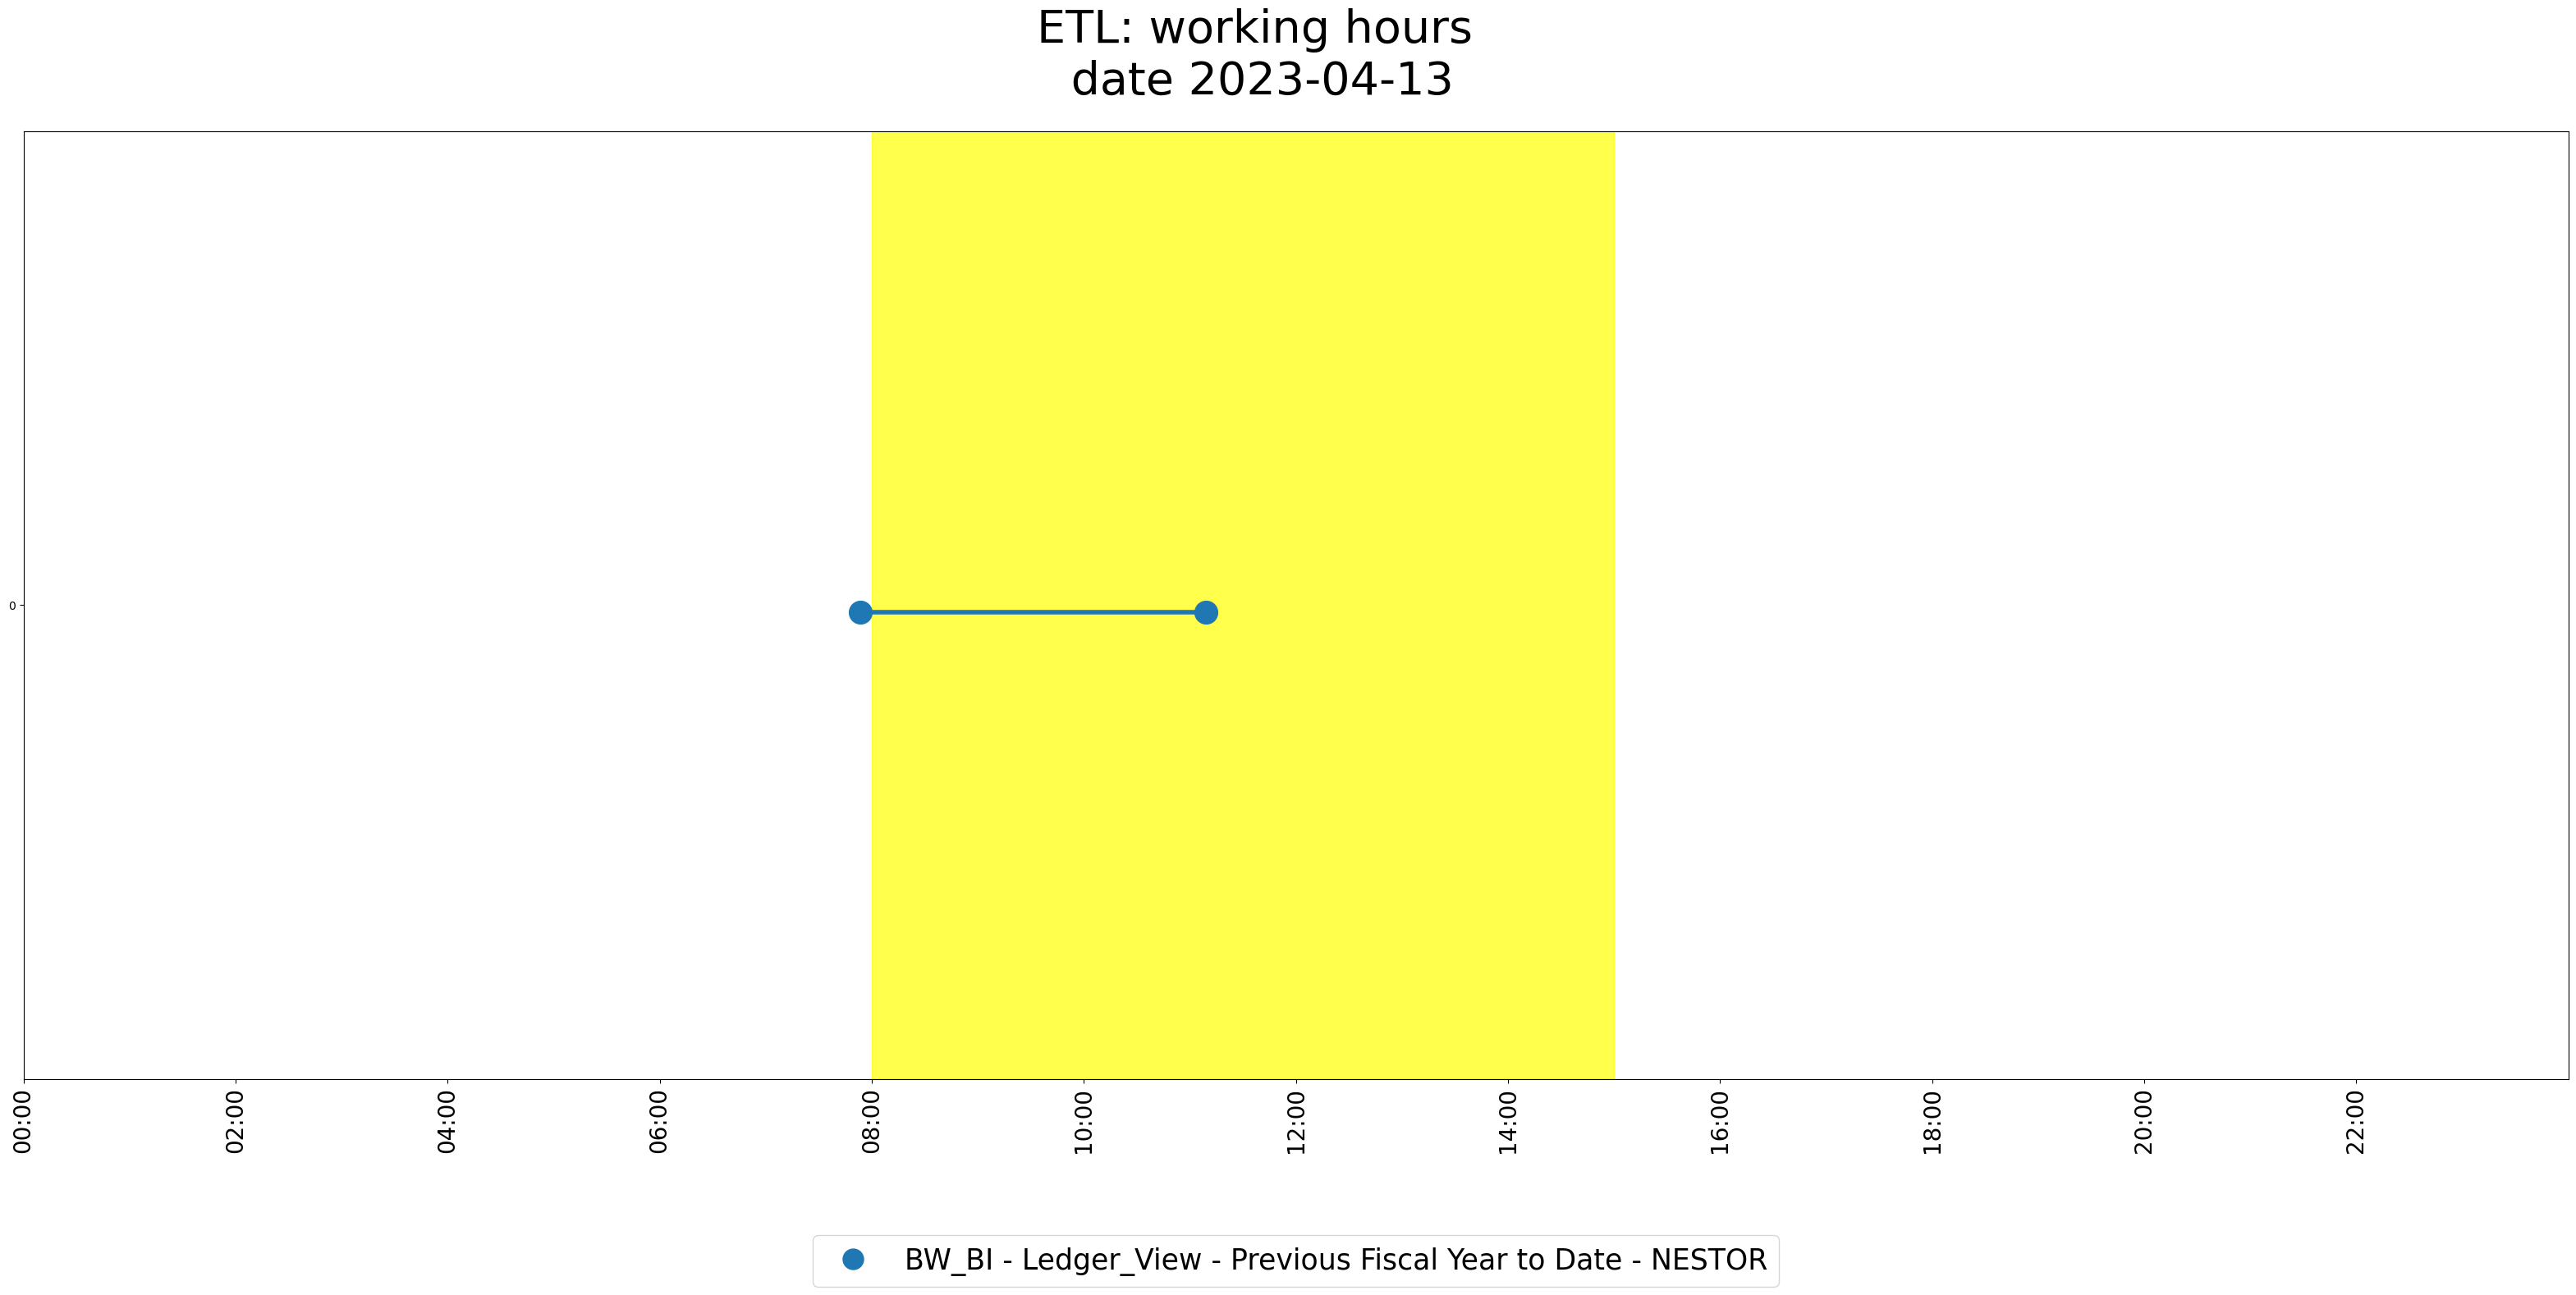

In [32]:
# Convert the Start_Time and End_Time columns to datetime64 data type
job_duration_plot_df['Start_Time'] = pd.to_datetime(job_duration_plot_df['Start_Time'], errors='coerce')
job_duration_plot_df['End_Time'] = pd.to_datetime(job_duration_plot_df['End_Time'], errors='coerce')

# Generate random names for the jobs
# Add a small random offset to the y-coordinate to separate jobs with the same name
job_duration_plot_df['Offset'] = np.random.uniform(-0.2, 0.2, size=len(job_duration_plot_df))
job_duration_plot_df['Y'] = job_duration_plot_df.index + job_duration_plot_df['Offset']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(40, 15))

# Set the x-axis limits from 00:00 to 24:00
ax.set_xlim(pd.Timestamp(date_str + ' 00:00:00'), pd.Timestamp(date_str+' 23:59:59'))


# Set the y-axis limits
ax.set_ylim(-0.5, len(job_duration_plot_df)-0.5)

# Plot the horizontal lines for the jobs and color them based on job name
color_list  = list(colors.TABLEAU_COLORS.values())[:len(job_duration_plot_df['Name'].unique())]
for name, color in zip(job_duration_plot_df['Name'].unique(), color_list):
    mask = job_duration_plot_df['Name'] == name
    ax.hlines(y=job_duration_plot_df[mask]['Y'], xmin=job_duration_plot_df[mask]['Start_Time'], 
              xmax=job_duration_plot_df[mask]['End_Time'], color=color, label=name)
    ax.plot(job_duration_plot_df[mask]['Start_Time'], job_duration_plot_df[mask]['Y'], 'o', color=color, markersize=8)
    ax.plot(job_duration_plot_df[mask]['End_Time'], job_duration_plot_df[mask]['Y'], 'o', color=color, markersize=8)

# Set the y-ticks to display the DataFrame index
ax.set_yticks(job_duration_plot_df.index)
ax.set_yticklabels(['{:.0f}'.format(x) for x in job_duration_plot_df.index])

# Set the x-tick interval to 2 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# Set the x-tick format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add a yellow transparent box between 8:00 and 17:00
ax.axvspan(datetime_8am, datetime_5pm, alpha=0.7, color='yellow')

# Rotate the x-tick labels by 90 degrees
plt.xticks(rotation=90, fontsize = 20)

# Set the x-axis
# Create a dictionary of colors for each job name
unique_names = job_duration_plot_df['Name'].unique()
name_color_dict = {name: color_list[i] for i, name in enumerate(unique_names)}

# Plot the horizontal lines for the jobs with the color of the job
for name in unique_names:
    job_subset = job_duration_plot_df[job_duration_plot_df['Name'] == name]
    ax.hlines(y=job_subset['Y'], xmin=job_subset['Start_Time'], xmax=job_subset['End_Time'], linewidth = 4, color=name_color_dict[name])
    ax.plot(job_subset['Start_Time'], job_subset['Y'], 'o', color=name_color_dict[name], markersize=20)
    ax.plot(job_subset['End_Time'], job_subset['Y'], 'o', color=name_color_dict[name], markersize=20)

# Create a legend connecting the index to name and color
#legend_text = [f'{name}: {job_duration_plot_df[job_duration_plot_df["Name"] == name]["Name"].to_numpy()[0]}' for name in unique_names]
legend_text = [f'{name}' for name in unique_names]

legend_elements = [mlines.Line2D([], [], marker='o', color='w', label=text, markerfacecolor=name_color_dict[name], markersize=20) for name, text in zip(unique_names, legend_text)]

# Add the legend
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(unique_names), fontsize = 25)

# add a title for the figure        
fig.suptitle(f'ETL: {my_desc}\n date {date_str}', fontsize = 40)

# Show the plot
plt.show()

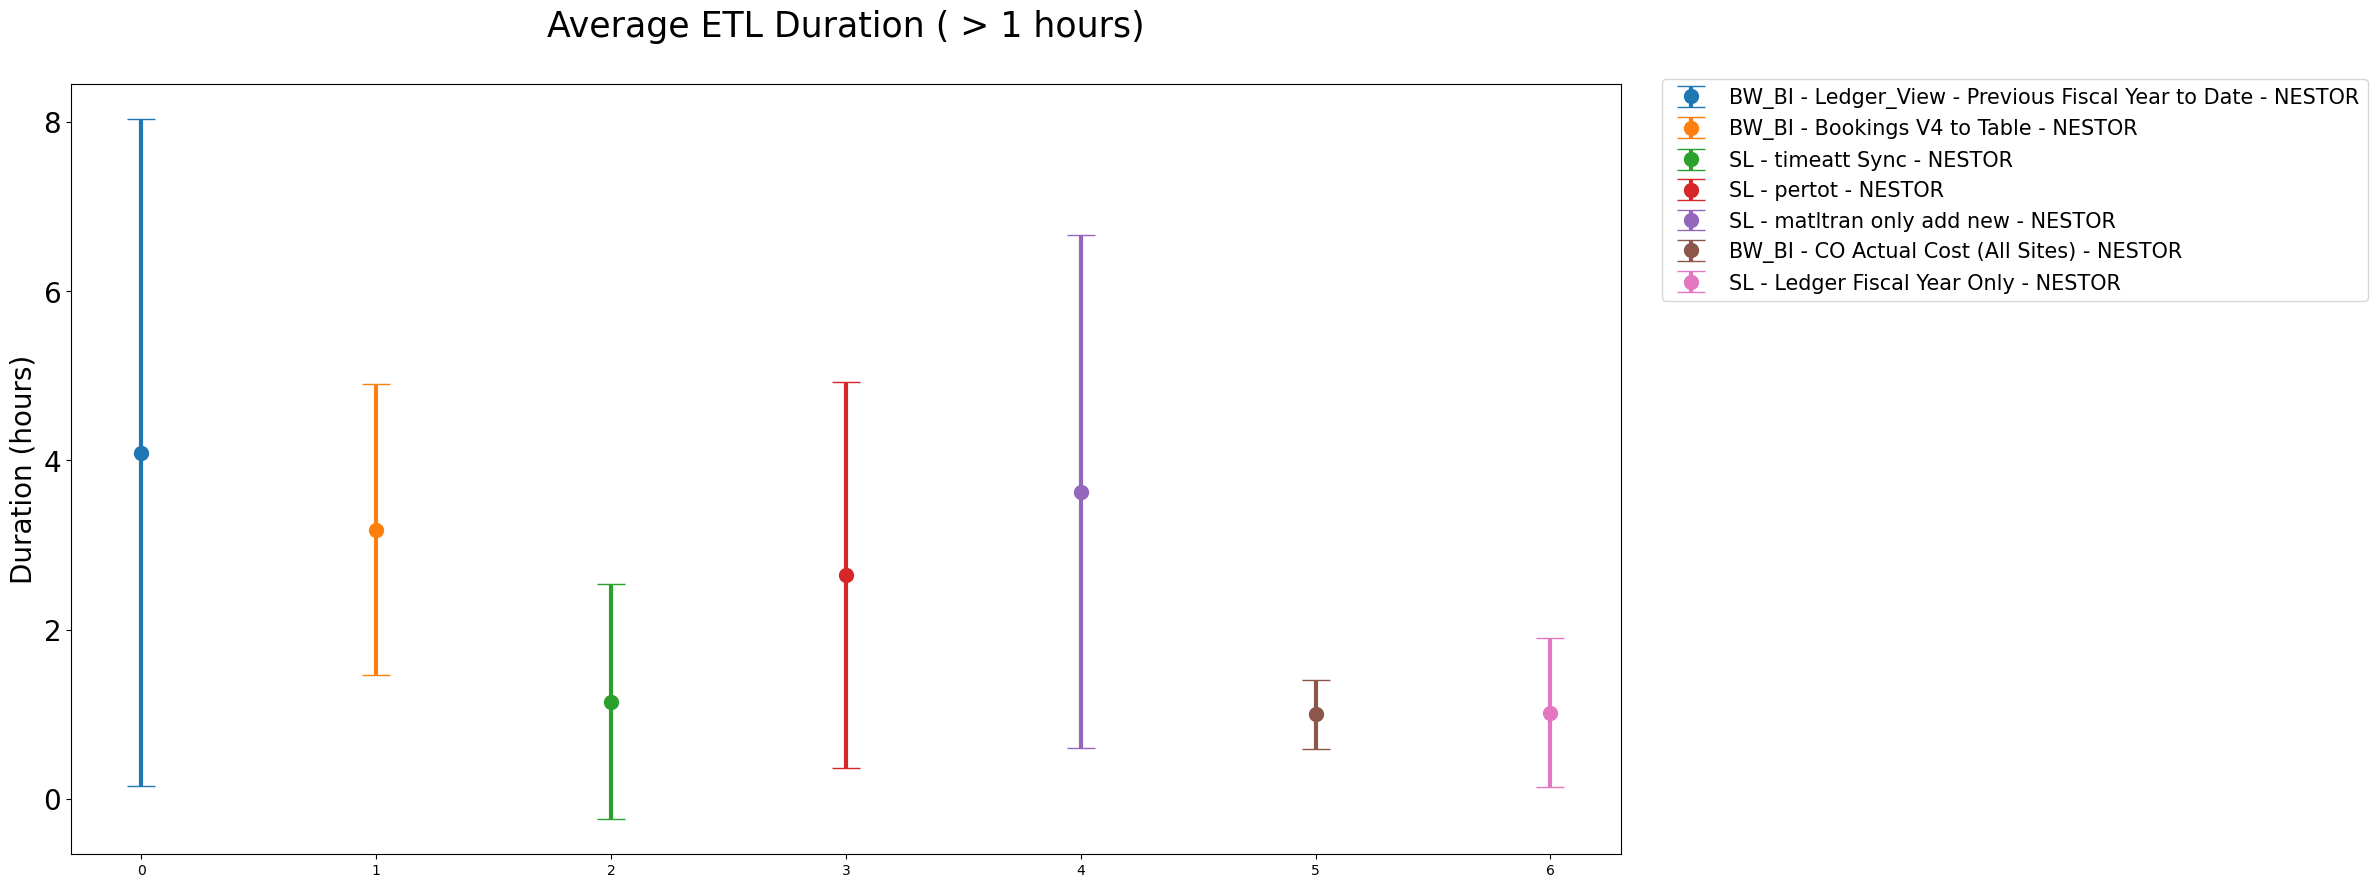

In [33]:

# jobs runbiung more then x hoursv (on average)
my_hours = 1
my_df = etl_avg_duration_df[etl_avg_duration_df["Duration (sec) Average"] >= my_hours * 60 * 60]
my_df = my_df.reset_index().copy()

# Convert duration from seconds to hours
my_df.loc[:, "Duration (sec) Average"] = np.round(my_df["Duration (sec) Average"] / 3600, 2)
my_df.loc[:, "Duration (sec) StDev"] = np.round(my_df["Duration (sec) StDev"] / 3600, 2)

# Rename the column
my_df = my_df.rename(columns={"Duration (sec) Average": "Duration (hours) Average", "Duration (sec) StDev": "Duration (hours) StDev"})

# PLotting Results
plt.figure(figsize = (20,10))

means = my_df['Duration (hours) Average'].tolist()
stds = my_df['Duration (hours) StDev'].tolist()
etl_names = my_df['Name'].tolist()
x_values = my_df.index.tolist()

color_list = list(colors.TABLEAU_COLORS.values())[:len(etl_names)]


for i in range(len(means)):
    plt.errorbar(x_values[i], means[i], yerr=stds[i], linewidth = 3, fmt='o',markersize=10, capsize=10, color=color_list[i], label=etl_names[i])
    
# Add legend
plt.legend(bbox_to_anchor=(1.02, 1.02), fontsize = 15)

# Add labels and title
plt.ylabel('Duration (hours)', fontsize = 20)
# increase tick size on y-axis
plt.tick_params(axis='y', labelsize=20)

#plt.xlabel('ETL Index')
plt.title(f'Average ETL Duration ( > {my_hours} hours)\n', fontsize = 25)

# Show the plot
plt.show()

## List of long ETLs (+ info) since our last meeting

In [26]:
my_study_df = odin_jobs_df[odin_jobs_df['Name'].isin(etl_names)].sort_values(by=['Name', 'Start_Time'])
my_study_df[my_study_df['Start_Time'] >= '2023-04-01'].style

,Name,Start_Time,End_Time,Duration_Seconds
4859,BW_BI - Bookings V4 to Table - NESTOR,2023-04-01 01:30:00,2023-04-01 08:20:22,24622
4463,BW_BI - Bookings V4 to Table - NESTOR,2023-04-02 01:30:00,2023-04-02 03:03:55,5635
4064,BW_BI - Bookings V4 to Table - NESTOR,2023-04-03 01:30:00,2023-04-03 05:47:25,15445
3668,BW_BI - Bookings V4 to Table - NESTOR,2023-04-04 01:30:00,2023-04-04 02:18:57,2937
3272,BW_BI - Bookings V4 to Table - NESTOR,2023-04-05 01:30:00,2023-04-05 07:18:40,20920
2872,BW_BI - Bookings V4 to Table - NESTOR,2023-04-06 01:30:00,2023-04-06 05:00:55,12655
2482,BW_BI - Bookings V4 to Table - NESTOR,2023-04-07 01:30:00,2023-04-07 04:38:55,11335
2090,BW_BI - Bookings V4 to Table - NESTOR,2023-04-08 01:30:00,2023-04-08 10:00:28,30628
1695,BW_BI - Bookings V4 to Table - NESTOR,2023-04-09 01:30:00,2023-04-09 05:48:38,15518
1302,BW_BI - Bookings V4 to Table - NESTOR,2023-04-10 01:30:00,2023-04-10 04:46:48,11808
